## Problem description

Success in any financial market requires one to identify solid investments. When a stock or derivative is undervalued, it makes sense to buy. If it's overvalued, perhaps it's time to sell. While these finance decisions were historically made manually by professionals, technology has ushered in new opportunities for retail investors. Data scientists, specifically, may be interested to explore quantitative trading, where decisions are executed programmatically based on predictions from trained models.

The competition will involve building portfolios from the stocks eligible for predictions (around 2,000 stocks). Specifically, each participant ranks the stocks from highest to lowest expected returns and is evaluated on the difference in returns between the top and bottom 200 stocks. You'll have access to financial data from the Japanese market, such as stock information and historical stock prices to train and test your model.

Detail about the evaluation metric is geiven https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

In [3]:
import os
from decimal import ROUND_HALF_UP, Decimal

from lightgbm import LGBMRegressor
from tqdm import tqdm

import matplotlib.pyplot as plt
import time as time

In [4]:
import xgboost as xgb

### Adjust close price and sharpe ratio metric

In [5]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

def set_rank(df, column='predict'):
    """
    Args:
        df (pd.DataFrame): including predict column
    Returns:
        df (pd.DataFrame): df with Rank
    """
    # sort records to set Rank
    df = df.sort_values(column, ascending=False)
    # set Rank starting from 0
    df.loc[:, "Rank"] = np.arange(len(df[column]))
    return df

def calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio, column):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')[column][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)[column][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, 
                              toprank_weight_ratio: float = 2, column: str = 'Target') -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """    

    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio, column)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio


In [6]:
# set base_dir to load data
base_dir = "../input/jpx-tokyo-stock-exchange-prediction"
# There are three types of stock_price.csv
# We use one in the train_files folder for this notebook.
train_files_dir = f"{base_dir}/train_files"

# for forecasting phase leaderboard, you may want to include stock_price.csv in the supplemental_files folder.
# You can remove "forecasting phase leaderboard" comments in this notebook to use stock_price.csv in the supplemental_files folder.
# forecasting phase leaderboard:
# supplemental_files_dir = f"{base_dir}/supplemental_files"

In [7]:
# load stock price data
df_stock_price = pd.read_csv(f"{train_files_dir}/stock_prices.csv")
df_stock_list=pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")
df_suppl_stocks = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv', 
                              parse_dates=["Date"])


# 1. Data exploration

In [8]:
print(df_stock_price.shape, df_suppl_stocks.shape, df_stock_price.shape[0] + df_suppl_stocks.shape[0])
df_stock_price = pd.concat([df_stock_price, df_suppl_stocks])
print(df_stock_price.shape)

df_stock_price = adjust_price(df_stock_price) #adjust_price deals with nan
df_stock_price.reset_index(inplace=True)
print(df_stock_price.shape)

## Droping not used fields
df_stock_price.drop(['RowId', 'ExpectedDividend', 'SupervisionFlag','AdjustmentFactor','CumulativeAdjustmentFactor','Close'], axis=1, inplace=True)
print(df_stock_price.shape)

# dropping rows where target is nan. Then, fill the remainded nan's with zero 
df_stock_price.dropna(subset=['Target'], inplace=True)
df_stock_price = df_stock_price.fillna(0)    
print(df_stock_price.shape)

(2332531, 12) (269881, 12) 2602412
(2602412, 12)
(2602412, 14)
(2602412, 8)
(2602166, 8)


### **Exploring the stock_list data**

See in: why we use the '33SectorCode' as inidiator to classify the series

In [9]:
## clean the space of 17SectorName 
df_stock_list['17SectorName'] = df_stock_list['17SectorName'].str.strip()
## ## grouped by 17SectorName we have 18 groups 
df_stock_list[['SecuritiesCode', '17SectorName']].groupby(['17SectorName']).count().sort_values('SecuritiesCode', ascending=False)
## grouped by '33SectorCode', and '17SectorName' we have 34 groups 
display((df_stock_list[['SecuritiesCode', '17SectorName', '33SectorCode']].groupby(['33SectorCode', '17SectorName']).count().sort_values('SecuritiesCode', ascending=False)).reset_index().sort_values('17SectorName'))

## Merge stocks with sectors data
df_stock_price = pd.merge(df_stock_price, df_stock_list[['33SectorCode', '17SectorName', 'SecuritiesCode']], on='SecuritiesCode', how='inner')
df_stock_price['33SectorCode'] = df_stock_price['33SectorCode'].astype(int)
print(df_stock_price.shape)

list_33SectorCode = df_stock_price[['SecuritiesCode','33SectorCode']].groupby('33SectorCode').count().reset_index().sort_values('SecuritiesCode', 
                                                                                                                                    ascending=False)['33SectorCode'].values    

,33SectorCode,17SectorName,SecuritiesCode
2,-,-,500
27,3350,AUTOMOBILES & TRANSPORTATION EQUIPMENT,19
12,3700,AUTOMOBILES & TRANSPORTATION EQUIPMENT,95
13,7050,BANKS,93
4,6050,COMMERCIAL & WHOLESALE TRADE,320
14,3550,CONSTRUCTION & MATERIALS,90
17,3400,CONSTRUCTION & MATERIALS,56
8,2050,CONSTRUCTION & MATERIALS,170
5,3650,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,255
19,3750,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,50


(2602166, 10)


In [10]:
df_stock_price

,Date,SecuritiesCode,Open,High,Low,Volume,Target,AdjustedClose,33SectorCode,17SectorName
0,2017-01-04,1301,2734.0,2755.0,2730.0,31400,0.000730,2742.0,50,FOODS
1,2017-01-05,1301,2743.0,2747.0,2735.0,17900,0.002920,2738.0,50,FOODS
2,2017-01-06,1301,2734.0,2744.0,2720.0,19900,-0.001092,2740.0,50,FOODS
3,2017-01-10,1301,2745.0,2754.0,2735.0,24200,-0.005100,2748.0,50,FOODS
4,2017-01-11,1301,2748.0,2752.0,2737.0,9300,-0.003295,2745.0,50,FOODS
...,...,...,...,...,...,...,...,...,...,...
2602161,2022-06-20,9997,693.0,697.0,683.0,122600,0.001416,687.0,6100,RETAIL TRADE
2602162,2022-06-21,9997,692.0,709.0,692.0,204800,0.000000,706.0,6100,RETAIL TRADE
2602163,2022-06-22,9997,706.0,716.0,703.0,150200,0.016973,707.0,6100,RETAIL TRADE
2602164,2022-06-23,9997,704.0,713.0,704.0,114700,0.013908,707.0,6100,RETAIL TRADE


# 2. Models

In [11]:
def generate_next_targets(df, column):
    def compute_lags(df, column):
        df['CloseNext'] = df[column].shift(-1)
        df['CloseNextNext'] = df[column].shift(-2)
        return df
    df = df.groupby('SecuritiesCode').apply(lambda x:compute_lags(x, column))
    return df

In [12]:
## Genrating CloseNext and CLoseNextNext columns
df_stock_price_next = generate_next_targets(df_stock_price, 'AdjustedClose')
df_stock_price_next.dropna(subset=['CloseNext', 'CloseNextNext'], inplace=True)
print('difference in size between df_stock_price and df_stock_price_next :', df_stock_price.shape, df_stock_price_next.shape)

difference in size between df_stock_price and df_stock_price_next : (2602166, 10) (2598166, 12)


## 2.1 Features

In [13]:
def percentage_change_feature(df, column, config_feature):
    for period in config_feature['periods']:        
        df["PC_"+str(period)] = df[column].pct_change(period) 
    return df

def volatility_feature(df, column, config_feature):
    for period in config_feature['periods']:        
        df["VOLAT_"+str(period)] = (np.log(df[column]).diff().rolling(period).std())
    return df

def moving_average_feature(df, column, config_feature):
    for period in config_feature['periods']:        
        df["MA_"+str(period)] = df[column].rolling(window=period).mean().values
    return df

def exponential_moving_average_feature(df, column, config_feature):
    for period in config_feature['periods']:        
        df["EMA_"+str(period)] = df[column].ewm(span=period,adjust=False).mean().values
    return df

def divergence(df, column, config_feature):
    for period in config_feature['periods']:        
        std = df[column].rolling(period, min_periods=1).std()
        mean = df[column].rolling(period, min_periods=1).mean()
        df["DIV_"+str(period)] = (df[column]-mean) / std  
    return df

def rsi(df, column, config_feature):
    # rate stregth index rsi=gain/(gain+loss)
    for period in config_feature['periods']:   
        df["RSI_"+str(period)] = (df[column] - df[column].shift(1)).rolling(period).apply(lambda s:s[s>0].sum()/abs(s).sum())
    return df

def stochastic(df, column, config_feature):
    
    _min = df[column].rolling(config_feature['k']).min()
    _max = df[column].rolling(config_feature['k']).max()
    _k = (df[column] - _min)/(_max - _min)
    _d1 = _k.rolling(config_feature['n']).mean()
    _d2 = _d1.rolling(config_feature['m']).mean()
    df["%K_"+str(config_feature['k'])] = _k
    df["%FAST-%D"+str(config_feature['n'])] = _d1
    df["%SLOW-%D"+str(config_feature['m'])] = _d2
    return df

def psy(df, column, config_feature):
    for period in config_feature['periods']:
        df["PSY_"+str(period)] = (df[column] - df[column].shift(1)).rolling(period).apply(lambda s:(s>=0).mean())
    return df

def ich(df, column, config_feature):
    df["CONV_"+str(config_feature['conv'])] = df[column].rolling(config_feature['conv']).apply(lambda s:(s.max()+s.min())/2) #5
    df["BASE_"+str(config_feature['base'])] = df[column].rolling(config_feature['base']).apply(lambda s:(s.max()+s.min())/2) #15
    df["PRE_1"] = ((df["CONV_"+str(config_feature['conv'])] + df["BASE_"+str(config_feature['base'])])/2).shift(config_feature['pre_1'])
    df["PRE_2"] = df[column].rolling(2*config_feature['base']).apply(lambda s:(s.max()+s.min())/2).shift(config_feature['pre_2'])
    #df["LAG_20"] = df[column].shift(20)
    return df

def compute_local_features(price, column="AdjustedClose", config_feature={}):

    if 'pc' in config_feature:
        price = percentage_change_feature(price, column, config_feature['pc'])
    if 'volat' in config_feature:
        price = volatility_feature(price, column, config_feature['volat'])
    if 'ma' in config_feature:
        price = moving_average_feature(price, column, config_feature['ma'])
    if 'ema' in config_feature:
        price = exponential_moving_average_feature(price, column, config_feature['ema'])
    if 'div' in config_feature:
        price = divergence(price, column, config_feature['div']) 
    if 'rsi' in config_feature:
        price = rsi(price, column, config_feature['rsi']) 
    if 'stochastic' in config_feature:
        price = stochastic(price, column, config_feature['stochastic'])
    if 'psy' in config_feature:
        price = psy(price, column, config_feature['psy'])
    if 'ich' in config_feature:
        price = ich(price, column, config_feature['ich'])
    
    
    # filling data for nan and inf
    price = price.fillna(0)
    price = price.replace([np.inf, -np.inf], 0)
    
    return price

def get_features(config_feature, df_stock_price):
    
    # generate features
    df_stock_price.set_index('SecuritiesCode', inplace=True)
    buff = []
    columns = config_feature['columns']
    over_column = config_feature['over_column']
    
    for code in df_stock_price.index.unique():
        feat = compute_local_features(df_stock_price.loc[code][columns].copy(), over_column, config_feature)
        buff.append(feat)
    df_features = pd.concat(buff)
    df_stock_price.reset_index(inplace=True)
    return df_features

### *Experiment with comunity features*

In [ ]:
### Testing features 
# df_tmp = df_stock_price[df_stock_price['SecuritiesCode'] == 1301]
# df_tmp = get_features(config_feature, df_tmp)
# df_tmp.columns
# date = slice('2020-12-01', '2023')
# df_tmp.set_index('Date').loc[date]['AdjustedClose'].plot(figsize=(10, 5), style='.')
# df_tmp.set_index('Date').loc[date][['DIV_5', 'DIV_15', 'DIV_30']].plot(figsize=(10, 5), style='.')
# df_tmp.set_index('Date').loc[date][['RSI_5', 'RSI_15', 'RSI_30']].plot(figsize=(10, 5), style='.')
# df_tmp.set_index('Date').loc[date][['%K_30', '%FAST-%D5', '%SLOW-%D15']].plot(figsize=(10, 5), style='.') 
# df_tmp.set_index('Date').loc[date][['PSY_5', 'PSY_15', 'PSY_30']].plot(figsize=(10, 5), style='.')
# df_tmp.set_index('Date').loc[date][['CONV_5', 'BASE_15', 'PRE_1', 'PRE_2']].plot(figsize=(10, 5), style='.')

# df_tmp.set_index('Date').loc[date][['PC_5', 'PC_15', 'PC_30']].plot(figsize=(10, 5))
# df_tmp.set_index('Date').loc[date][['VOLAT_5','VOLAT_15', 'VOLAT_30']].plot(figsize=(10, 5))
# df_tmp.set_index('Date').loc[date][['AdjustedClose', 'MA_5', 'MA_15', 'MA_30']].plot(figsize=(10, 5))
# df_tmp.set_index('Date').loc[date][['AdjustedClose', 'EMA_5', 'EMA_15','EMA_30']].plot(figsize=(10, 5))


## 2.2 Evaluation

In [14]:
import IPython
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error


In [15]:
def train_model(param_tmp, x_train, y_train, x_val, y_val, early_stoping=False, 
                early_stopping_rounds=50, verbose=True):    
    model = XGBRegressor(learning_rate = param_tmp['learning_rate'], 
                         max_depth = param_tmp['max_depth'],
                         min_child_weight = param_tmp['min_child_weight'],
                         subsample = param_tmp['subsample'],
                         colsample_bytree = param_tmp['colsample_bytree'],
                         reg_alpha = param_tmp['reg_alpha'],
                         n_estimators = param_tmp['n_estimators']) 
    
    if early_stoping:                
        eval_set = [(x_val, y_val)]
        model.fit(x_train, y_train, early_stopping_rounds=early_stopping_rounds,  
                  eval_set=eval_set, verbose=verbose)
    else:
        
        model.fit(x_train, y_train)

    y_pred_train = model.predict(x_train)  
    y_pred_val = model.predict(x_val)               

    df_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
    df_rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val, multioutput='raw_values'))   
    
    return model, df_rmse_train, df_rmse_val

def plot_examples_performance(df_train_raw, df_test_raw, list_models_from_hp_search, config_feature, model_type='Target', 
                              num_models=2, num_series=3, date_to_plot=slice('2021-01-01', '2022')):
    
    fig, ax = plt.subplots(2, num_series, figsize=[30,20])
    
    if model_type=='Target' :
        config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', 'Target']
    if model_type=='CloseNext' or model_type=='CloseNextNext':
        config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', 'CloseNext', 'CloseNextNext']
    
    i = 0         
    random_models = np.random.choice(np.arange(len(list_models_from_hp_search[model_type])), num_models, replace=False)
    print(random_models)
    for index_model in random_models:
        dic_model = list_models_from_hp_search[model_type][index_model]
        code_sector = dic_model['code_sector']
        model_tmp = dic_model['model']    

        x_train = get_features(config_feature, df_train_raw.loc[code_sector])            
        x_test = get_features(config_feature, df_test_raw.loc[code_sector])    

        j = 0
        random_stocks = np.random.choice(x_train.index.unique(), num_series, replace=False)
        for code_stock in random_stocks:
            x_predict_train_tmp = x_train.loc[code_stock][['Date', model_type]].copy()
            x_predict_train_tmp['Predict_Train'] = model_tmp.predict(x_train.loc[code_stock][FEATURES].values) 

            x_predict_test_tmp = x_test.loc[code_stock][['Date', model_type]].copy()
            x_predict_test_tmp['Predict_Test'] = model_tmp.predict(x_test.loc[code_stock][FEATURES].values) 

            x_predict_train_tmp.set_index('Date').loc[date_to_plot].plot(style='.', ax=ax[i][j])
            x_predict_test_tmp.set_index('Date').loc[date_to_plot].plot(style='.', ax=ax[i][j])

            j += 1

        i += 1
        

### **Partition data and features configuration**

In [17]:
## config list to save the results
list_metrics_from_hp_search = {'Target':[], 'CloseNext':[], 'CloseNextNext':[]}
list_hp_from_hp_search = {'Target':[], 'CloseNext':[], 'CloseNextNext':[]}
list_models_from_hp_search = {'Target':[], 'CloseNext':[], 'CloseNextNext':[]}

TRAIN_START = '2020-12-23' #2017-01-04
TRAIN_END = '2021-11-19' 
TEST_START = '2021-12-06'

'''
df_stock_price range date [ 2017-01-04 , 2021-12-03 ]
df_suppl_stocks range date [ 2021-12-06 00:00:00 , 2022-06-24 00:00:00 ]
'''

## config features
config_feature = {'pc':{'periods':[5, 10, 15, 20, 30]}, 
                  'volat':{'periods':[5, 10, 15, 20, 30]},
                  'ma':{'periods':[5, 10, 15, 20, 30]},
                  'ema':{'periods':[5, 10, 15, 20, 30]},                                  
                  'over_column':'AdjustedClose',                  
                  'columns':['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose']}

FEATURES = [
            'Open', 'High', 'Low', 'Volume', 'AdjustedClose',  #as features
            'PC_5', 'PC_15', 'PC_30', 'PC_10', 'PC_20',          
            'VOLAT_5', 'VOLAT_15', 'VOLAT_30', 'VOLAT_10', 'VOLAT_20',
            'MA_5', 'MA_15', 'MA_30','MA_10', 'MA_20',          
            'EMA_5', 'EMA_15', 'EMA_30','EMA_10', 'EMA_20'   
          ]

### **Data from Model 1: Model Target**

In [18]:
TARGET = ['Target']
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', TARGET[0]]

NUM_MODELS = 33

#if TARGET[0] == 'Target':
df_train_model_target_raw = df_stock_price.set_index('Date').loc[TRAIN_START:TRAIN_END, :]
df_test_model_target_raw= df_stock_price.set_index('Date').loc[TEST_START:, :]  
    
print('Target :', TARGET, ', NUM_MODELS:', NUM_MODELS, ', len features:',len(FEATURES))

print(df_train_model_target_raw.index)
print(df_test_model_target_raw.index)
## 33 models using the 33SectorCode code sectors
if NUM_MODELS == 33:
    list_codes_models = list_33SectorCode.copy()

    df_train_model_target_raw.reset_index(inplace=True)
    df_train_model_target_raw.set_index('33SectorCode', inplace=True)
    display(df_train_model_target_raw.head(3))

    df_test_model_target_raw.reset_index(inplace=True)
    df_test_model_target_raw.set_index('33SectorCode', inplace=True)
    display(df_test_model_target_raw.head(3))

print(len(list_metrics_from_hp_search['Target']))
print(len(list_hp_from_hp_search['Target']))
print(len(list_models_from_hp_search['Target']))    

Target : ['Target'] , NUM_MODELS: 33 , len features: 25
DatetimeIndex(['2020-12-23', '2020-12-24', '2020-12-25', '2020-12-28',
               '2020-12-29', '2020-12-30', '2021-01-04', '2021-01-05',
               '2021-01-06', '2021-01-07',
               ...
               '2021-11-08', '2021-11-09', '2021-11-10', '2021-11-11',
               '2021-11-12', '2021-11-15', '2021-11-16', '2021-11-17',
               '2021-11-18', '2021-11-19'],
              dtype='datetime64[ns]', name='Date', length=446000, freq=None)
DatetimeIndex(['2021-12-06', '2021-12-07', '2021-12-08', '2021-12-09',
               '2021-12-10', '2021-12-13', '2021-12-14', '2021-12-15',
               '2021-12-16', '2021-12-17',
               ...
               '2022-06-13', '2022-06-14', '2022-06-15', '2022-06-16',
               '2022-06-17', '2022-06-20', '2022-06-21', '2022-06-22',
               '2022-06-23', '2022-06-24'],
              dtype='datetime64[ns]', name='Date', length=269873, freq=None)


,Date,SecuritiesCode,Open,High,Low,Volume,Target,AdjustedClose,17SectorName
33SectorCode,,,,,,,,,
50,2020-12-23,1301,2913.0,2920.0,2906.0,6300,-0.000343,2913.0,FOODS
50,2020-12-24,1301,2913.0,2937.0,2909.0,13900,0.011660,2917.0,FOODS
50,2020-12-25,1301,2903.0,2930.0,2903.0,8300,0.003729,2916.0,FOODS


,Date,SecuritiesCode,Open,High,Low,Volume,Target,AdjustedClose,17SectorName
33SectorCode,,,,,,,,,
50,2021-12-06,1301,2982.0,2982.0,2965.0,8900,-0.003263,2971.0,FOODS
50,2021-12-07,1301,2998.0,3065.0,2990.0,19100,0.009820,3065.0,FOODS
50,2021-12-08,1301,3080.0,3080.0,3035.0,11600,0.006483,3055.0,FOODS


0
0
0


### **Data from Model 2: Model Next**

In [19]:
TARGETS = [['CloseNext'], ['CloseNextNext']] 
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', 'Target', TARGETS[0][0], TARGETS[1][0]]

NUM_MODELS = 33

#if ((TARGET[0][0] == 'CloseNext') or (TARGET[1][0] == 'CloseNextNext')): 
df_train_model_next_raw = df_stock_price_next.set_index('Date').loc[TRAIN_START:TRAIN_END, :]
df_test_model_next_raw = df_stock_price_next.set_index('Date').loc[TEST_START:, :]  

print('Target :', TARGETS, ', NUM_MODELS:', NUM_MODELS, ', len features:',len(FEATURES))

print(df_train_model_next_raw.index)
print(df_test_model_next_raw.index)
## 33 models using the 33SectorCode code sectors
if NUM_MODELS == 33:
    list_codes_models = list_33SectorCode.copy()
        
    df_train_model_next_raw.reset_index(inplace=True)
    df_train_model_next_raw.set_index('33SectorCode', inplace=True)
    display(df_train_model_next_raw.head(3))

    df_test_model_next_raw.reset_index(inplace=True)
    df_test_model_next_raw.set_index('33SectorCode', inplace=True)
    display(df_test_model_next_raw.head(3))
    
print(len(list_metrics_from_hp_search['CloseNext']), len(list_metrics_from_hp_search['CloseNextNext']))
print(len(list_hp_from_hp_search['CloseNext']), len(list_hp_from_hp_search['CloseNextNext']))
print(len(list_models_from_hp_search['CloseNext']), len(list_models_from_hp_search['CloseNextNext']))

Target : [['CloseNext'], ['CloseNextNext']] , NUM_MODELS: 33 , len features: 25
DatetimeIndex(['2020-12-23', '2020-12-24', '2020-12-25', '2020-12-28',
               '2020-12-29', '2020-12-30', '2021-01-04', '2021-01-05',
               '2021-01-06', '2021-01-07',
               ...
               '2021-11-08', '2021-11-09', '2021-11-10', '2021-11-11',
               '2021-11-12', '2021-11-15', '2021-11-16', '2021-11-17',
               '2021-11-18', '2021-11-19'],
              dtype='datetime64[ns]', name='Date', length=446000, freq=None)
DatetimeIndex(['2021-12-06', '2021-12-07', '2021-12-08', '2021-12-09',
               '2021-12-10', '2021-12-13', '2021-12-14', '2021-12-15',
               '2021-12-16', '2021-12-17',
               ...
               '2022-06-09', '2022-06-10', '2022-06-13', '2022-06-14',
               '2022-06-15', '2022-06-16', '2022-06-17', '2022-06-20',
               '2022-06-21', '2022-06-22'],
              dtype='datetime64[ns]', name='Date', length=26587

,Date,SecuritiesCode,Open,High,Low,Volume,Target,AdjustedClose,17SectorName,CloseNext,CloseNextNext
33SectorCode,,,,,,,,,,,
50,2020-12-23,1301,2913.0,2920.0,2906.0,6300,-0.000343,2913.0,FOODS,2917.0,2916.0
50,2020-12-24,1301,2913.0,2937.0,2909.0,13900,0.011660,2917.0,FOODS,2916.0,2950.0
50,2020-12-25,1301,2903.0,2930.0,2903.0,8300,0.003729,2916.0,FOODS,2950.0,2961.0


,Date,SecuritiesCode,Open,High,Low,Volume,Target,AdjustedClose,17SectorName,CloseNext,CloseNextNext
33SectorCode,,,,,,,,,,,
50,2021-12-06,1301,2982.0,2982.0,2965.0,8900,-0.003263,2971.0,FOODS,3065.0,3055.0
50,2021-12-07,1301,2998.0,3065.0,2990.0,19100,0.009820,3065.0,FOODS,3055.0,3085.0
50,2021-12-08,1301,3080.0,3080.0,3035.0,11600,0.006483,3055.0,FOODS,3085.0,3105.0


0 0
0 0
0 0


### **Load models from hyperparameters previously computed**


In [20]:
def map_features_to_config(list_features, over_column):
    list_columns = []
    config = {}
    for feature in list_features:        
        sub_string = feature.split('_')        
        if len(sub_string)>1:
            if sub_string[0].lower() in config: 
                config[sub_string[0].lower()]['periods'].append(int(sub_string[1]))
            else:
                config[sub_string[0].lower()] = {'periods':[int(sub_string[1])]}
        else:
            list_columns.append(sub_string[0])        
            
    if over_column in list_columns:
        config['columns'] = list_columns
    else:
        list_columns.append(over_column)        
        config['columns'] = list_columns
    config['over_column'] = over_column
    
    return config 

In [112]:
def train_models_from_hp_search(type_model, df_train_raw, df_test_raw, config_feature, list_hp_from_hp_search, with_early_stoping=False, 
                                with_important_features=False, dic_name_features_from_hp_search=None):
            
    list_models = []
    list_metrics = []
    FEATURES_TMP = FEATURES # global variable

    # for code_sec in tqdm(list_sector_ids):
    #for code_sec in tqdm(list_codes_models):
    for dic_hp in tqdm(list_hp_from_hp_search[type_model]):

        code_sec = dic_hp['code_sec']
        best_hp = dic_hp['hp']

        if with_important_features:
            if dic_name_features_from_hp_search is not None:                
                config_feature = map_features_to_config(dic_name_features_from_hp_search[type_model][code_sec], 'AdjustedClose')
                config_feature['columns'].append(type_model)
                FEATURES_TMP = dic_name_features_from_hp_search[type_model][code_sec]

        print('------------------------------------')
        print('TARGET: ', type_model)
        print(config_feature)
        print(FEATURES_TMP)
        print('------------------------------------')

        x_train_raw = df_train_raw.loc[code_sec].copy()
        x_test_raw = df_test_raw.loc[code_sec].copy()

        print("\ntrain:", x_train_raw.shape, " test:", x_test_raw.shape)

        print('n_estimator before', best_hp['n_estimators'] )
        best_hp['n_estimators'] = 200 #set a large initial value
        #best_hp = list_hp_over_test[i]

        print('\ncomputing features train and test ...')
        x_train = get_features(config_feature, x_train_raw)            
        x_test = get_features(config_feature, x_test_raw)
        print('training model ...')
        model, df_rmse_train, df_rmse_test = train_model(best_hp, x_train[FEATURES_TMP].values, x_train[[type_model]].values, 
                                                         x_test[FEATURES_TMP].values, x_test[[type_model]].values,
                                                         early_stoping=with_early_stoping, early_stopping_rounds=10, verbose=False)
        best_hp['n_estimators'] = model.best_iteration
        #list_hp_over_test.append(best_hp)
        print('n_estimator after :', model.best_iteration)
        print('rmse train:', df_rmse_train.mean(),' rmse test:', df_rmse_test.mean(),'\n')
        list_metrics.append({'rmse train':df_rmse_train.mean(), 'rmse test':df_rmse_test.mean()})
        list_models.append({'code_sector':code_sec, 'model':model})

    IPython.display.clear_output()

    return list_models, list_metrics

In [22]:
# hyperparameters previously computed
list_hp_from_hp_search = {'Target': [{'code_sec': 5250, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 9050, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 6100, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3650, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 6050, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3200, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3600, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 2050, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3050, 'hp': {'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 5.0, 'subsample': 1.0, 'colsample_bytree': 0.1, 'reg_alpha': 0.8, 'n_estimators': 100}}, {'code_sec': 8050, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 7050, 'hp': {'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 6.0, 'subsample': 0.23582554361513935, 'colsample_bytree': 0.49739228265538016, 'reg_alpha': 0.4644097585144098, 'n_estimators': 70}}, {'code_sec': 3700, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3800, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3250, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 5050, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3550, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3750, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3400, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 7200, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3450, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 4050, 'hp': {'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 6.0, 'subsample': 0.25373413612716045, 'colsample_bytree': 0.1345337003121378, 'reg_alpha': 0.6645258832334391, 'n_estimators': 100}}, {'code_sec': 3500, 'hp': {'learning_rate': 0.05, 'max_depth': 14, 'min_child_weight': 6.0, 'subsample': 0.37169397388093395, 'colsample_bytree': 0.9286222375358582, 'reg_alpha': 0.4236339871088993, 'n_estimators': 100}}, {'code_sec': 3100, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 7100, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 5200, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3350, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 7150, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3150, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3300, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.3857295336929416, 'colsample_bytree': 0.8062588523202435, 'reg_alpha': 0.6509458999458535, 'n_estimators': 70}}, {'code_sec': 50, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 5100, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 1050, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 5150, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}], 
                          'CloseNext': [{'code_sec': 5250, 'hp': {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1.0, 'subsample': 0.1, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'n_estimators': 100}}, {'code_sec': 9050, 'hp': {'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 1.0, 'subsample': 0.1, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 100}}, {'code_sec': 6100, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.13448905757106563, 'n_estimators': 70}}, {'code_sec': 3650, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 100}}, {'code_sec': 6050, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 100}}, {'code_sec': 3200, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3600, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5.0, 'subsample': 0.7120212886709164, 'colsample_bytree': 0.6525271575884272, 'reg_alpha': 0.7089780915554322, 'n_estimators': 50}}, {'code_sec': 2050, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.7839376721943314, 'colsample_bytree': 0.3608827198820379, 'reg_alpha': 0.550403034671434, 'n_estimators': 70}}, {'code_sec': 3050, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 100}}, {'code_sec': 8050, 'hp': {'learning_rate': 0.05, 'max_depth': 14, 'min_child_weight': 10.0, 'subsample': 0.5662004703177551, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'n_estimators': 100}}, {'code_sec': 7050, 'hp': {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 5.0, 'subsample': 0.37083972103601803, 'colsample_bytree': 0.4604823216987435, 'reg_alpha': 0.6848957951297721, 'n_estimators': 100}}, {'code_sec': 3700, 'hp': {'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5.0, 'subsample': 0.48938018506847236, 'colsample_bytree': 0.4108503274802473, 'reg_alpha': 0.6668613367625343, 'n_estimators': 50}}, {'code_sec': 3800, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.5353668934035383, 'colsample_bytree': 0.4624061566662929, 'reg_alpha': 0.2235691502207009, 'n_estimators': 50}}, {'code_sec': 3250, 'hp': {'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 1.0, 'subsample': 0.9816058507156278, 'colsample_bytree': 0.8973012849254975, 'reg_alpha': 0.42627136586544134, 'n_estimators': 50}}, {'code_sec': 5050, 'hp': {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6.0, 'subsample': 0.20344053821591518, 'colsample_bytree': 0.8954477566805268, 'reg_alpha': 0.30096170070949346, 'n_estimators': 100}}, {'code_sec': 3550, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5.0, 'subsample': 0.8879969794798925, 'colsample_bytree': 0.9290567199029525, 'reg_alpha': 0.5010054884596418, 'n_estimators': 100}}, {'code_sec': 3750, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 6.0, 'subsample': 0.5791878353092663, 'colsample_bytree': 0.7429664388459756, 'reg_alpha': 0.7397344559427136, 'n_estimators': 70}}, {'code_sec': 3400, 'hp': {'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 10.0, 'subsample': 0.9314667013165719, 'colsample_bytree': 1.0, 'reg_alpha': 0.7402513809673599, 'n_estimators': 100}}, {'code_sec': 7200, 'hp': {'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5.0, 'subsample': 0.7681792196442041, 'colsample_bytree': 0.5920156605417045, 'reg_alpha': 0.17638310702372992, 'n_estimators': 70}}, {'code_sec': 3450, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 70}}, {'code_sec': 4050, 'hp': {'learning_rate': 0.05, 'max_depth': 14, 'min_child_weight': 10.0, 'subsample': 0.1, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 100}}, {'code_sec': 3500, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3100, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 10.0, 'subsample': 0.8521906029009632, 'colsample_bytree': 0.6944152571706641, 'reg_alpha': 0.7918105118809877, 'n_estimators': 50}}, {'code_sec': 7100, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 5200, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3350, 'hp': {'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 10.0, 'subsample': 0.5392359621764138, 'colsample_bytree': 0.49234616014433374, 'reg_alpha': 0.4242529312616313, 'n_estimators': 100}}, {'code_sec': 7150, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'n_estimators': 70}}, {'code_sec': 3150, 'hp': {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6.0, 'subsample': 0.1, 'colsample_bytree': 0.8887339232884883, 'reg_alpha': 0.8, 'n_estimators': 100}}, {'code_sec': 3300, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 50, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 5100, 'hp': {'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 6.0, 'subsample': 0.8236173669433973, 'colsample_bytree': 0.989532072631244, 'reg_alpha': 0.5225887215821481, 'n_estimators': 50}}, {'code_sec': 1050, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5.0, 'subsample': 0.7137909921682516, 'colsample_bytree': 0.7865469598822306, 'reg_alpha': 0.3391720080041173, 'n_estimators': 70}}, {'code_sec': 5150, 'hp': {'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 10.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.13599901565452271, 'n_estimators': 70}}], 
                          'CloseNextNext': [{'code_sec': 5250, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1.0, 'subsample': 0.1, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 100}}, {'code_sec': 9050, 'hp': {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 5.0, 'subsample': 0.11867138360321391, 'colsample_bytree': 0.25942976477122287, 'reg_alpha': 0.12552858825822177, 'n_estimators': 100}}, {'code_sec': 6100, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5.0, 'subsample': 0.8487557563785227, 'colsample_bytree': 0.8131699699830769, 'reg_alpha': 0.15259028326034785, 'n_estimators': 70}}, {'code_sec': 3650, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5.0, 'subsample': 0.35589719076489146, 'colsample_bytree': 0.6005591779309979, 'reg_alpha': 0.5959504595257163, 'n_estimators': 100}}, {'code_sec': 6050, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.9682389214212486, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3200, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.5827622688700153, 'colsample_bytree': 0.627339843827266, 'reg_alpha': 0.31485699002041245, 'n_estimators': 70}}, {'code_sec': 3600, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 100}}, {'code_sec': 2050, 'hp': {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5.0, 'subsample': 0.343813506002604, 'colsample_bytree': 0.5115820210474289, 'reg_alpha': 0.7354912577111853, 'n_estimators': 100}}, {'code_sec': 3050, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 70}}, {'code_sec': 8050, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 10.0, 'subsample': 0.7074717292371898, 'colsample_bytree': 0.46516167980721557, 'reg_alpha': 0.44632050535582, 'n_estimators': 100}}, {'code_sec': 7050, 'hp': {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6.0, 'subsample': 0.13418126069280176, 'colsample_bytree': 0.49093671722946863, 'reg_alpha': 0.13807023485507608, 'n_estimators': 100}}, {'code_sec': 3700, 'hp': {'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 10.0, 'subsample': 0.48591456667350086, 'colsample_bytree': 0.5368390293531794, 'reg_alpha': 0.47625021411909907, 'n_estimators': 70}}, {'code_sec': 3800, 'hp': {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 5.0, 'subsample': 0.5765172173899906, 'colsample_bytree': 0.738128048723157, 'reg_alpha': 0.4870130564691917, 'n_estimators': 100}}, {'code_sec': 3250, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 5050, 'hp': {'learning_rate': 0.05, 'max_depth': 14, 'min_child_weight': 10.0, 'subsample': 0.1, 'colsample_bytree': 0.4558361011217932, 'reg_alpha': 0.1, 'n_estimators': 100}}, {'code_sec': 3550, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 10.0, 'subsample': 0.9529058283345513, 'colsample_bytree': 0.5769418446034318, 'reg_alpha': 0.3150831240243918, 'n_estimators': 70}}, {'code_sec': 3750, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 3400, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.3498154863183146, 'n_estimators': 70}}, {'code_sec': 7200, 'hp': {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6.0, 'subsample': 0.28420974816440936, 'colsample_bytree': 0.9735589236576673, 'reg_alpha': 0.7950672017539306, 'n_estimators': 100}}, {'code_sec': 3450, 'hp': {'learning_rate': 0.05, 'max_depth': 14, 'min_child_weight': 6.0, 'subsample': 0.37396163160016904, 'colsample_bytree': 0.4722678075880751, 'reg_alpha': 0.27982941868416417, 'n_estimators': 100}}, {'code_sec': 4050, 'hp': {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 5.0, 'subsample': 0.19824954666255662, 'colsample_bytree': 0.39081090562326615, 'reg_alpha': 0.6900826399243803, 'n_estimators': 100}}, {'code_sec': 3500, 'hp': {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.6241308977935334, 'colsample_bytree': 0.8687537522916343, 'reg_alpha': 0.26803041089503943, 'n_estimators': 100}}, {'code_sec': 3100, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 7100, 'hp': {'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5.0, 'subsample': 0.47946354434697236, 'colsample_bytree': 0.8562661778394041, 'reg_alpha': 0.14952130744519868, 'n_estimators': 70}}, {'code_sec': 5200, 'hp': {'learning_rate': 0.05, 'max_depth': 14, 'min_child_weight': 10.0, 'subsample': 0.6788106578790152, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'n_estimators': 100}}, {'code_sec': 3350, 'hp': {'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 6.0, 'subsample': 0.6903948463790621, 'colsample_bytree': 0.6708359081599127, 'reg_alpha': 0.12690889003736056, 'n_estimators': 50}}, {'code_sec': 7150, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.5486587184144532, 'colsample_bytree': 0.5114873574976068, 'reg_alpha': 0.7170906382092468, 'n_estimators': 70}}, {'code_sec': 3150, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10.0, 'subsample': 0.1, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 100}}, {'code_sec': 3300, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5.0, 'subsample': 0.6917310629355784, 'colsample_bytree': 0.2967385723672401, 'reg_alpha': 0.28325660178176354, 'n_estimators': 70}}, {'code_sec': 50, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 5100, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 1050, 'hp': {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 100}}, {'code_sec': 5150, 'hp': {'learning_rate': 0.05, 'max_depth': 14, 'min_child_weight': 10.0, 'subsample': 0.6758053684859375, 'colsample_bytree': 0.7666690963426459, 'reg_alpha': 0.6905408177060831, 'n_estimators': 100}}]}

print(len(list_hp_from_hp_search['Target']))
print(len(list_hp_from_hp_search['CloseNext']))
print(len(list_hp_from_hp_search['CloseNextNext']))

In [23]:
list_metrics_from_hp_search = {'Target':[], 'CloseNext':[], 'CloseNextNext':[]}
list_models_from_hp_search = {'Target':[], 'CloseNext':[], 'CloseNextNext':[]}

In [24]:
type_model = 'Target'
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', type_model]
list_models_from_hp_search[type_model], list_metrics_from_hp_search[type_model] = train_models_from_hp_search(type_model, df_train_model_target_raw, 
                                                                                                              df_test_model_target_raw, config_feature, 
                                                                                                              list_hp_from_hp_search)

In [25]:
type_model = 'CloseNext'
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', type_model]
list_models_from_hp_search[type_model], list_metrics_from_hp_search[type_model] = train_models_from_hp_search(type_model, df_train_model_next_raw, 
                                                                                                              df_test_model_next_raw, config_feature, 
                                                                                                              list_hp_from_hp_search)

In [26]:
type_model = 'CloseNextNext'
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', type_model]
list_models_from_hp_search[type_model], list_metrics_from_hp_search[type_model] = train_models_from_hp_search(type_model, df_train_model_next_raw, 
                                                                                                              df_test_model_next_raw, config_feature, 
                                                                                                              list_hp_from_hp_search)

In [27]:
print(len(list_models_from_hp_search['Target']), len(list_metrics_from_hp_search['Target']))
print(len(list_models_from_hp_search['CloseNext']), len(list_metrics_from_hp_search['CloseNext']))
print(len(list_models_from_hp_search['CloseNextNext']), len(list_metrics_from_hp_search['CloseNextNext']))

33 33
33 33
33 33


### Ploting examples of performance

[21  6]


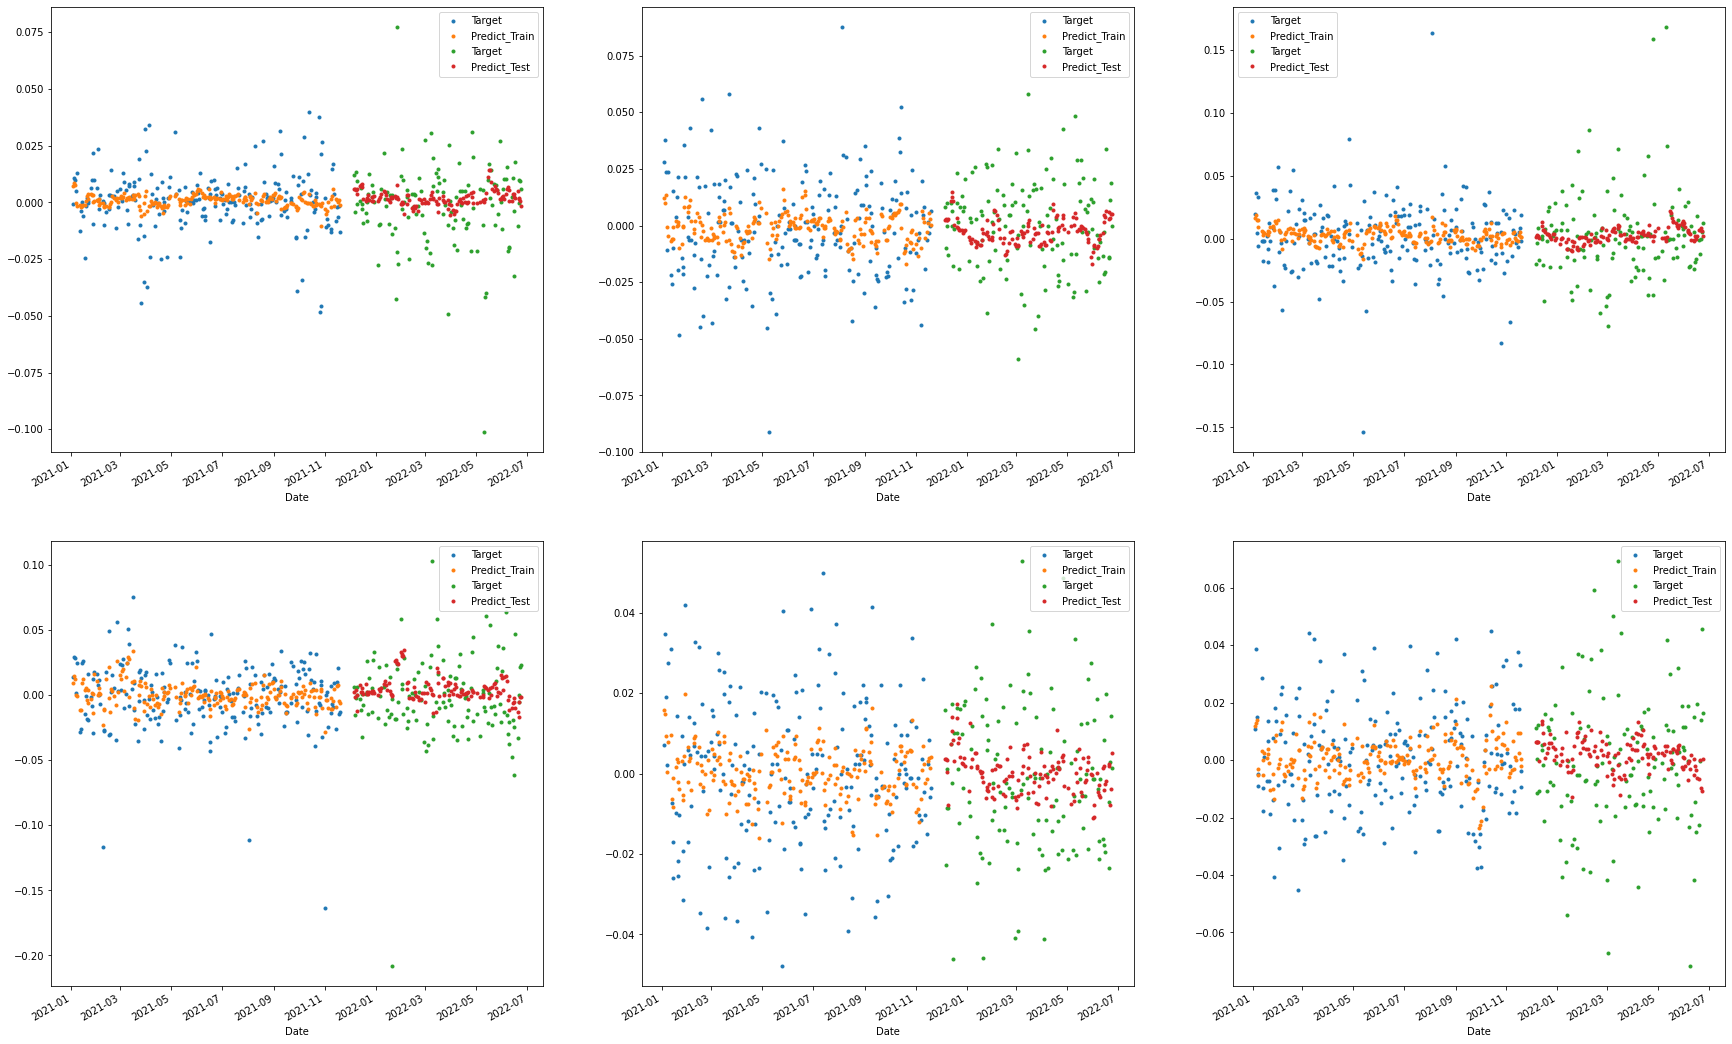

In [28]:
plot_examples_performance(df_train_model_target_raw, df_test_model_target_raw, list_models_from_hp_search, config_feature, 
                          model_type='Target',  num_models=2, num_series=3, date_to_plot=slice('2021-01-01', '2022'))

[11 12]


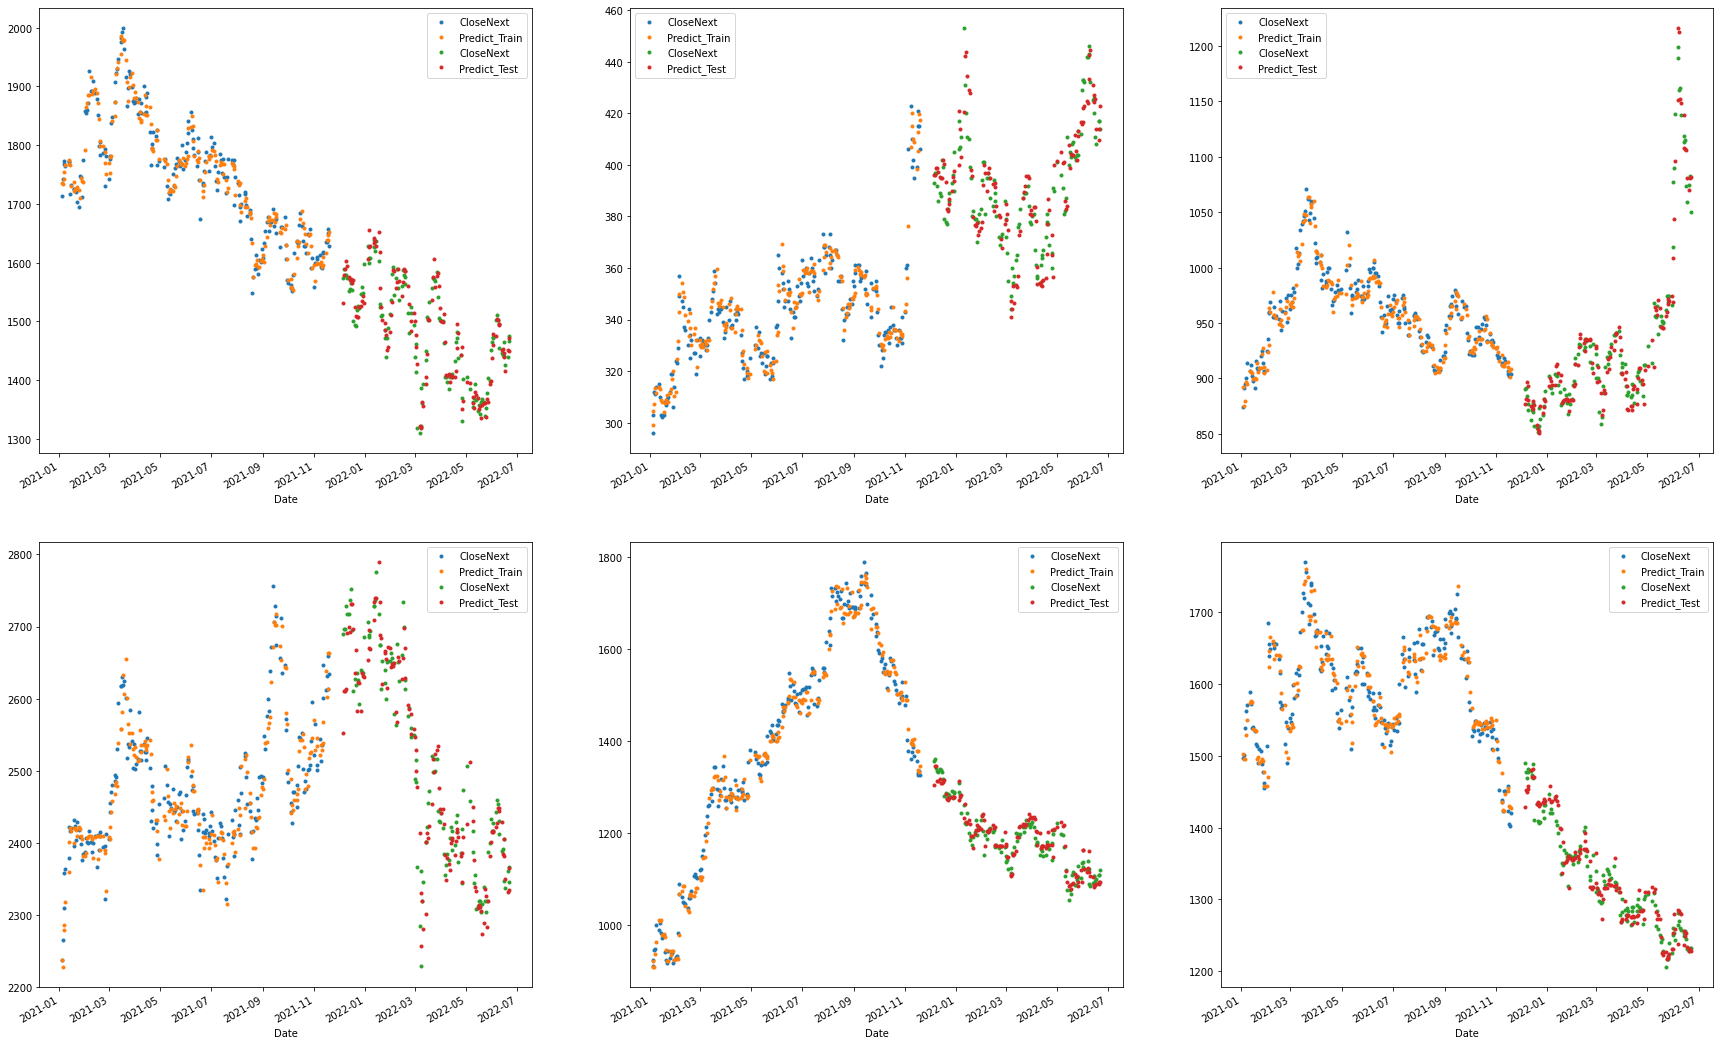

In [29]:
plot_examples_performance(df_train_model_next_raw, df_test_model_next_raw, list_models_from_hp_search, config_feature, 
                          model_type='CloseNext',  num_models=2, num_series=3, date_to_plot=slice('2021-01-01', '2022'))

[19 30]


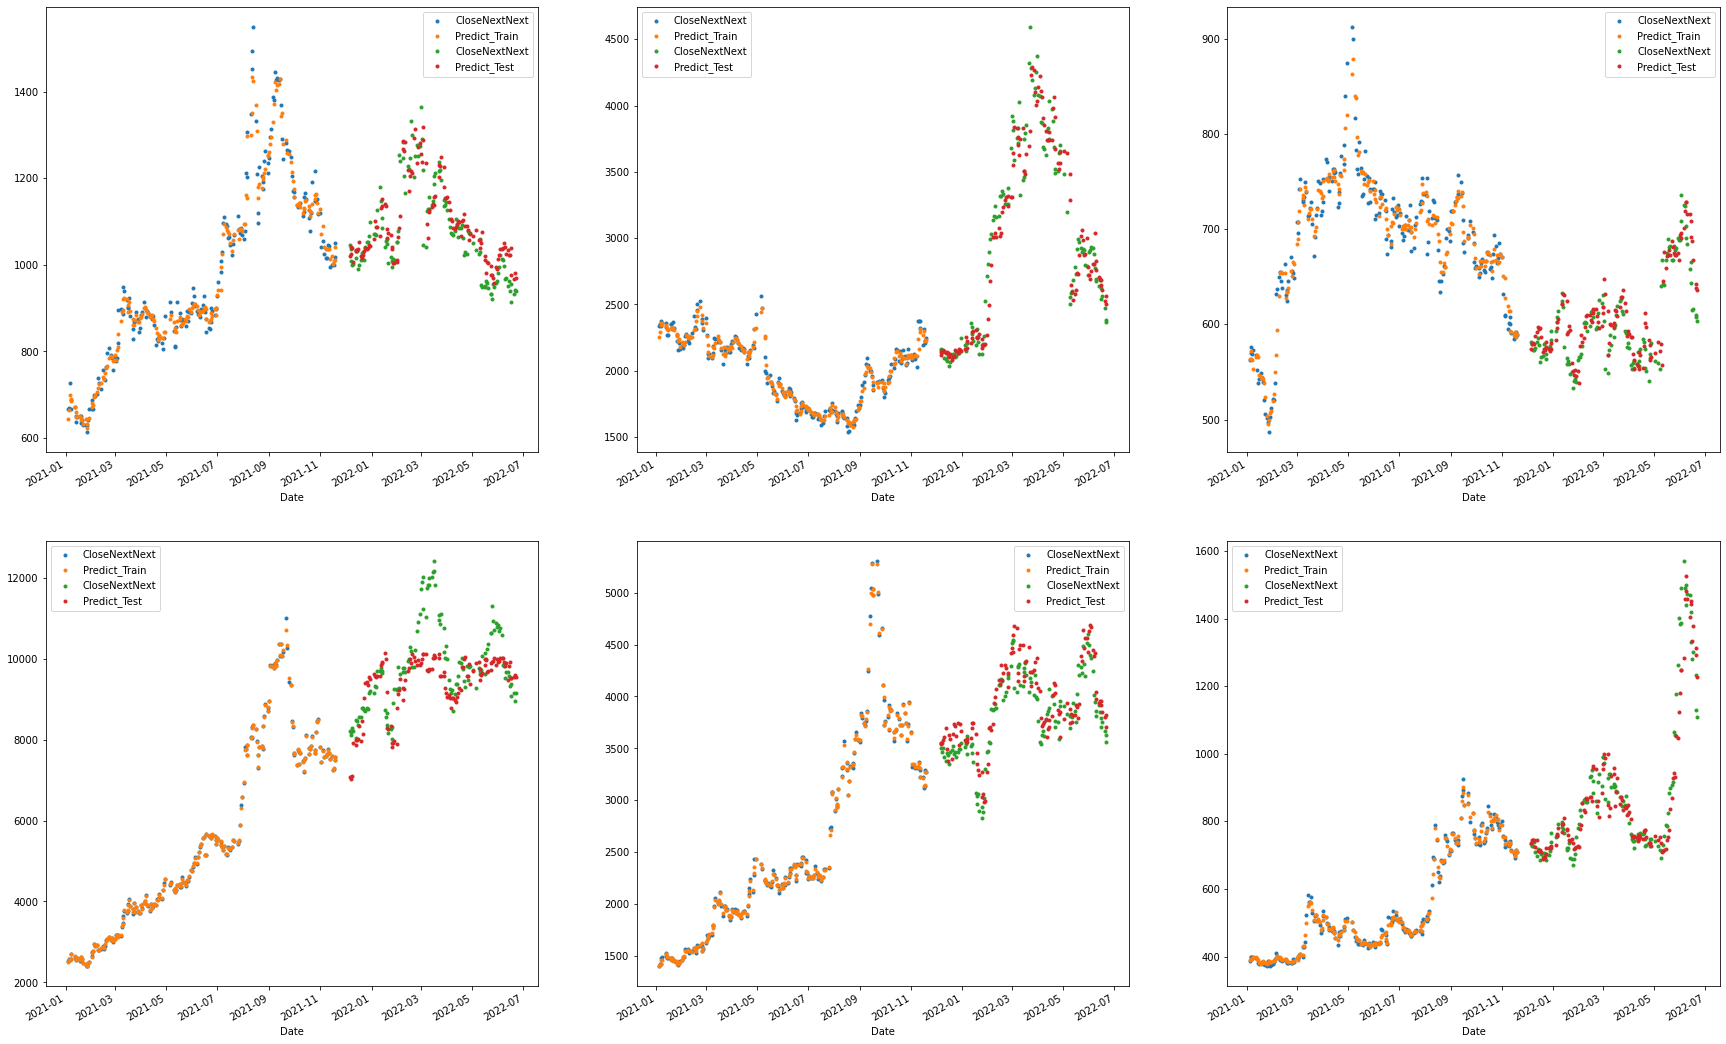

In [30]:
plot_examples_performance(df_train_model_next_raw, df_test_model_next_raw, list_models_from_hp_search, config_feature, 
                          model_type='CloseNextNext',  num_models=2, num_series=3, date_to_plot=slice('2021-01-01', '2022'))

# **Evaluation**

In [64]:
class Models_sector:
    def __init__(self, list_models, dict_important_features=None, list_features=None):
        self.list_models = list_models 
        self.dict_important_features = dict_important_features
        #list of features defined in the global variable FEATURES
        self.list_features = list_features 
        
        if self.dict_important_features is None:
            self.get_name_features()
        
    def get_name_features(self):
        #when important features were not computed
        self.dict_important_features = {}
        
        if type(self.list_models) is list:
            for dic in self.list_models:
                self.dict_important_features[dic['code_sector']] = self.list_features
                
        if type(self.list_models) is dict:
            for key in self.list_models.keys():
                self.dict_important_features[key] = {}
                for dic in self.list_models[key]:
                    self.dict_important_features[key][dic['code_sector']] = self.list_features
            
            
    def predict_from_features(self, x, target_column=None):
        
        x.reset_index(inplace=True)                
        if target_column is not None:
            columns=['33SectorCode', 'Date', 'SecuritiesCode'] + columns_in_output
        else:
            columns=['33SectorCode', 'Date', 'SecuritiesCode']
        df_result = x[columns].copy()
        df_result['Predict'] = 0.0        
            
        x.set_index('33SectorCode', inplace=True)        
        df_result.set_index('33SectorCode', inplace=True)                
            
        list_pred = []
        list_metric = []
        for i in range(len(self.list_models)):
            code_sector = self.list_models[i]['code_sector']
            model = self.list_models[i]['model']
            
            list_features = self.dict_important_features[code_sector]
            
            y_pred = model.predict(x.loc[code_sector][list_features])
            df_result.loc[code_sector, 'Predict'] = y_pred                        
            
        return df_result
    
    def predict_from_features_close_next(self, x, columns_in_output=None, name_models=[]):
        
        x.reset_index(inplace=True)                
        if target_column is not None:
            columns=['33SectorCode', 'Date', 'SecuritiesCode'] + columns_in_output
        else:
            columns=['33SectorCode', 'Date', 'SecuritiesCode']
        df_result = x[columns].copy()
        df_result['Predict'] = 0.0        
            
        x.set_index('33SectorCode', inplace=True)        
        df_result.set_index('33SectorCode', inplace=True)                
            
        list_pred = []
        list_metric = []
        for i in range(len(self.list_models[name_models[0]])):
            code_sector_0 = self.list_models[name_models[0]][i]['code_sector']
            code_sector_1 = self.list_models[name_models[1]][i]['code_sector']
            
            list_features_0 = self.dict_important_features[name_models[0]][code_sector_0]
            list_features_1 = self.dict_important_features[name_models[1]][code_sector_1]
            
            if code_sector_0 != code_sector_1:
                print('Error !!')
                break
                
            model_n = self.list_models[name_models[0]][i]['model']
            model_nn = self.list_models[name_models[1]][i]['model']
            
            y_pred_n = model_n.predict(x.loc[code_sector_0][list_features_0])
            y_pred_nn = model_nn.predict(x.loc[code_sector_1][list_features_1])
            
            df_result.loc[code_sector_0, 'Predict'] = self.compute_return(y_pred_n, y_pred_nn)                                          
            
        return df_result
    
    def predict_from_raw_data(self, df_raw, config_feature, 
                              columns_in_output=None, name_predict_column='Predict'):
        
        df_raw.reset_index(inplace=True)                
        if columns_in_output is not None:
            columns=['33SectorCode', 'Date', 'SecuritiesCode'] + columns_in_output
        else:
            columns=['33SectorCode', 'Date', 'SecuritiesCode']
        df_result = df_raw[columns].copy()
        df_result[name_predict_column] = 0.0        
            
        df_raw.set_index('33SectorCode', inplace=True)        
        df_result.set_index('33SectorCode', inplace=True)                
            
        list_pred = []
        list_metric = []
        for i in range(len(self.list_models)):
            code_sector = self.list_models[i]['code_sector']
            
            print('computing features model: ', code_sector)
            x_feat = get_features(config_feature, df_raw.loc[code_sector])
            
            #select the most important ones for the model
            list_features = self.dict_important_features[code_sector] 
            
            model = self.list_models[i]['model']
            y_pred = model.predict(x_feat[list_features])
            df_result.loc[code_sector, name_predict_column] = y_pred
                        
        return df_result
    
    def predict_from_raw_data_close_next(self, df_raw, config_feature, 
                                         columns_in_output=None, name_predict_column='Predict',
                                         name_models=['CloseNext', 'CloseNextNext']):
        
        df_raw.reset_index(inplace=True)                
        if columns_in_output is not None:
            columns=['33SectorCode', 'Date', 'SecuritiesCode'] + columns_in_output
        else:
            columns=['33SectorCode', 'Date', 'SecuritiesCode']
        df_result = df_raw[columns].copy()
        df_result[name_predict_column] = 0.0        
            
        df_raw.set_index('33SectorCode', inplace=True)        
        df_result.set_index('33SectorCode', inplace=True)                
            
        list_pred = []
        list_metric = []
        num_models = len(self.list_models[name_models[0]])
        for i in range(num_models):
            code_sector_0 = self.list_models[name_models[0]][i]['code_sector']
            code_sector_1 = self.list_models[name_models[1]][i]['code_sector']
            if code_sector_0 != code_sector_1:
                print('Error !!')
                break
            
            print('computing features models: ', code_sector_0)
            x_feat = get_features(config_feature, df_raw.loc[code_sector_0])  
            
            list_features_0 = self.dict_important_features[name_models[0]][code_sector_0]
            list_features_1 = self.dict_important_features[name_models[1]][code_sector_1]
            
            model_n = self.list_models[name_models[0]][i]['model']
            model_nn = self.list_models[name_models[1]][i]['model']
            y_pred_n = model_n.predict(x_feat[list_features_0])
            y_pred_nn = model_nn.predict(x_feat[list_features_1])
            df_result.loc[code_sector_0, name_predict_column] = self.compute_return(y_pred_n, y_pred_nn)
                        
        return df_result
    
    def compute_return(self, close_n, close_nn):
        return (close_nn - close_n)/close_n
        
    def compute_metric(self, y, y_pred):
        return np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))   
            

In [56]:
## compute predictions for trainig and testing
type_model = 'Target'
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', type_model]
model_target = Models_sector(list_models_from_hp_search[type_model], list_features=FEATURES)

In [57]:
## For the Target model
df_prediction_train = model_target.predict_from_raw_data(
    df_train_model_target_raw,
    config_feature,    
    columns_in_output=['Target'], #what we want to include in the output
    name_predict_column='Predict'
)
display(df_prediction_train)

df_prediction_test = model_target.predict_from_raw_data(
    df_test_model_target_raw,
    config_feature,    
    columns_in_output=['Target'],
    name_predict_column='Predict'
)
display(df_prediction_test)

## For train 
result_train = df_prediction_train.sort_values(["Date", 'Predict'], ascending=[True, False])

result_train_rank_by_target = result_train.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Target'))
result_train_rank_by_pred = result_train.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Predict'))

sharpe_target_train = calc_spread_return_sharpe(result_train_rank_by_target[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(), 
                                          portfolio_size=200, column='Target')
sharpe_predict_train = calc_spread_return_sharpe(result_train_rank_by_pred[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(), 
                                           portfolio_size=200, column='Predict')

print('sharpe_target_train: ', sharpe_target_train,  ' sharpe_predict_train:', sharpe_predict_train)
print('rmse train:', model_target.compute_metric(result_train['Target'], result_train['Predict']))
print('-------------------------------------')


## For Test
result_test = df_prediction_test.sort_values(["Date", "Predict"], ascending=[True, False])

result_test_rank_by_target = result_test.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Target'))
result_test_rank_by_pred = result_test.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Predict'))

sharpe_target_test = calc_spread_return_sharpe(result_test_rank_by_target[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(),
                                               portfolio_size=200, column='Target')
sharpe_predict_test = calc_spread_return_sharpe(result_test_rank_by_pred[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(), 
                                                portfolio_size=200, column='Predict')

print('sharpe_target_test: ', sharpe_target_test,  ' sharpe_predict_test:', sharpe_predict_test)
print('rmse test:', model_target.compute_metric(result_test['Target'], result_test['Predict']))

computing features


/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features


,Date,SecuritiesCode,Target,Predict
33SectorCode,,,,
50,2020-12-23,1301,-0.000343,0.003612
50,2020-12-24,1301,0.011660,0.004505
50,2020-12-25,1301,0.003729,0.003633
50,2020-12-28,1301,-0.003377,0.004137
50,2020-12-29,1301,-0.000339,0.002680
...,...,...,...,...
6100,2021-11-15,9997,0.004104,-0.001431
6100,2021-11-16,9997,-0.024523,-0.004569
6100,2021-11-17,9997,0.000000,-0.003837


metrics for train:  [0.01533633]
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features
computing features


,Date,SecuritiesCode,Target,Predict
33SectorCode,,,,
50,2021-12-06,1301,-0.003263,0.004491
50,2021-12-07,1301,0.009820,0.005407
50,2021-12-08,1301,0.006483,0.004604
50,2021-12-09,1301,-0.006441,0.004604
50,2021-12-10,1301,-0.008104,0.003396
...,...,...,...,...
6100,2022-06-20,9997,0.001416,-0.004229
6100,2022-06-21,9997,0.000000,0.001073
6100,2022-06-22,9997,0.016973,-0.002803


metrics for test:  [0.02490954]
sharpe_target_train:  5.754757777792205  sharpe_predict_train: 5.623279073620296
rmse train: [0.01533633]
-------------------------------------
sharpe_target_test:  4.854682801006776  sharpe_predict_test: 10.546479123933262
rmse test: [0.02490954]


In [134]:
## compute predictions for trainig and testing
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', 'CloseNext', 'CloseNextNext']
models_next = Models_sector({'CloseNext':list_models_from_hp_search['CloseNext'], 
                             'CloseNextNext':list_models_from_hp_search['CloseNextNext']}, 
                            list_features=FEATURES)

In [135]:
## For the Next model
df_prediction_next_train = models_next.predict_from_raw_data_close_next(
    df_train_model_next_raw,
    config_feature,    
    columns_in_output=['Target', 'CloseNext', 'CloseNextNext'],
    name_predict_column='Predict',
    name_models = ['CloseNext', 'CloseNextNext']
)
IPython.display.clear_output()
display(df_prediction_next_train)

df_prediction_next_test = models_next.predict_from_raw_data_close_next(
    df_test_model_next_raw,
    config_feature,    
    columns_in_output=['Target', 'CloseNext', 'CloseNextNext'],
    name_predict_column='Predict',
    name_models = ['CloseNext', 'CloseNextNext']
)
IPython.display.clear_output()
display(df_prediction_next_test)

## For train 
result_train = df_prediction_next_train.sort_values(["Date", 'Predict'], ascending=[True, False])

result_train_rank_by_target = result_train.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Target'))
result_train_rank_by_pred = result_train.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Predict'))

sharpe_target_train = calc_spread_return_sharpe(result_train_rank_by_target[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(), 
                                          portfolio_size=200, column='Target')
sharpe_predict_train = calc_spread_return_sharpe(result_train_rank_by_pred[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(), 
                                           portfolio_size=200, column='Predict')

print('sharpe_target_train: ', sharpe_target_train,  ' sharpe_predict_train:', sharpe_predict_train)
print('rmse train:', models_next.compute_metric(result_train['Target'], result_train['Predict']))


## For Test
result_test = df_prediction_next_test.sort_values(["Date", "Predict"], ascending=[True, False])

result_test_rank_by_target = result_test.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Target'))
result_test_rank_by_pred = result_test.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Predict'))

sharpe_target_test = calc_spread_return_sharpe(result_test_rank_by_target[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(),
                                               portfolio_size=200, column='Target')
sharpe_predict_test = calc_spread_return_sharpe(result_test_rank_by_pred[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(), 
                                                portfolio_size=200, column='Predict')

print('sharpe_target_test: ', sharpe_target_test,  ' sharpe_predict_test:', sharpe_predict_test)
print('rmse test:', models_next.compute_metric(result_test['Target'], result_test['Predict']))


,Date,SecuritiesCode,Target,CloseNext,CloseNextNext,Predict
33SectorCode,,,,,,
50,2021-12-06,1301,-0.003263,3065.0,3055.0,0.004294
50,2021-12-07,1301,0.009820,3055.0,3085.0,0.012158
50,2021-12-08,1301,0.006483,3085.0,3105.0,0.012421
50,2021-12-09,1301,-0.006441,3105.0,3085.0,0.012378
50,2021-12-10,1301,-0.008104,3085.0,3060.0,0.011769
...,...,...,...,...,...,...
6100,2022-06-16,9997,-0.008658,693.0,687.0,0.012439
6100,2022-06-17,9997,0.027656,687.0,706.0,0.012439
6100,2022-06-20,9997,0.001416,706.0,707.0,0.011940


sharpe_target_train:  5.754757777792205  sharpe_predict_train: 8.865912144025986
rmse train: [0.02124988]
sharpe_target_test:  4.857388253761368  sharpe_predict_test: 10.904149782012583
rmse test: [0.03154717]


# [Optional] Retrain using the test data as validation 

1. Feature selection based on the feature importance for the model
2. Retrain using only the most relevant features
3. Use early stoping using the test data as validation
**Warning!!** It could be, or not benefitial competition purpose 


In [95]:
### **compute most respresentative features for each model**
def compute_representative_features(list_models, list_features, select_perce=0.5, show_cum_sum=False):

    dic_representative_features = {}

    ## Show what features are important for the model
    for dic_model in list_models:

        model_tmp = dic_model['model']
        code_sec = dic_model['code_sector']    

        #fig, ax  = plt.subplots(1,1, figsize=[10,10])
        #xgb.plot_importance(model_tmp, ax=ax)
    
        df_features_importance = pd.DataFrame(model_tmp.feature_importances_, columns=['importance'])
        df_features_importance['feature'] = list_features
        df_features_importance = df_features_importance.sort_values('importance', ascending=False)
        df_features_importance['cum_sum_import'] = df_features_importance['importance'].cumsum()
        if show_cum_sum:
            display(df_features_importance)
            
        df_features_importance = df_features_importance[df_features_importance['cum_sum_import'] <=select_perce]

        dic_representative_features[code_sec] = df_features_importance['feature'].to_list()
        print(dic_representative_features[code_sec])

    return dic_representative_features


In [102]:
dict_represent_features_by_model = {'Target':[], 'CloseNext':[], 'CloseNextNext':[]}

In [103]:

dict_result = compute_representative_features(list_models_from_hp_search['Target'], FEATURES, select_perce=0.25, show_cum_sum=False)
dict_represent_features_by_model['Target']=dict_result

['EMA_10', 'EMA_30', 'EMA_20', 'EMA_5']
['EMA_20', 'EMA_15', 'MA_20', 'EMA_5', 'EMA_10']
['MA_30', 'MA_10', 'EMA_5', 'EMA_15', 'EMA_10']
['MA_20', 'PC_20', 'EMA_5', 'EMA_30', 'MA_30']
['EMA_20', 'MA_5', 'EMA_15', 'MA_30']
['EMA_30', 'VOLAT_30', 'EMA_20', 'MA_10', 'VOLAT_20']
['EMA_10', 'MA_20', 'EMA_20', 'MA_10', 'EMA_5']
['EMA_20', 'EMA_30', 'EMA_10', 'MA_15', 'EMA_15']
['EMA_30', 'VOLAT_5', 'MA_30']
['EMA_20', 'EMA_10', 'EMA_15', 'Low', 'MA_5']
['EMA_10', 'PC_5', 'PC_15', 'MA_10', 'PC_10']
['EMA_20', 'High', 'EMA_5', 'VOLAT_20', 'MA_20']
['MA_10', 'EMA_20', 'AdjustedClose', 'MA_15', 'VOLAT_30']
['EMA_30', 'EMA_20', 'EMA_10', 'MA_20', 'VOLAT_20']
['EMA_5', 'EMA_30', 'MA_30', 'MA_20', 'PC_5']
['EMA_20', 'EMA_30', 'PC_15', 'MA_30', 'PC_10']
['EMA_10', 'EMA_5', 'MA_20', 'EMA_20']
['MA_10', 'EMA_15', 'EMA_20', 'EMA_10', 'MA_20']
['EMA_20', 'MA_30', 'VOLAT_20', 'VOLAT_30', 'EMA_30']
['MA_10', 'EMA_15', 'MA_15', 'MA_20', 'EMA_10']
['VOLAT_10', 'PC_5']
['EMA_10', 'MA_30', 'MA_10', 'MA_15']
[

In [104]:

dict_result = compute_representative_features(list_models_from_hp_search['CloseNext'], FEATURES, select_perce=0.99, show_cum_sum=False)
dict_represent_features_by_model['CloseNext']=dict_result

['AdjustedClose', 'EMA_5', 'Open', 'High', 'EMA_20', 'MA_10', 'Low', 'EMA_10', 'EMA_15', 'EMA_30', 'MA_5', 'MA_30', 'MA_15', 'MA_20']
['EMA_5', 'AdjustedClose', 'High', 'MA_15', 'Open', 'Low', 'MA_20', 'MA_30', 'MA_5', 'EMA_20']
['Open', 'AdjustedClose', 'EMA_15', 'Low', 'EMA_5']
['Low', 'AdjustedClose', 'High', 'EMA_5']
['AdjustedClose', 'EMA_5']
['AdjustedClose', 'EMA_5']
['High', 'AdjustedClose', 'Open', 'Low', 'EMA_5']
['EMA_15', 'AdjustedClose', 'EMA_20', 'EMA_5', 'High', 'EMA_10', 'Low', 'EMA_30', 'Open']
['AdjustedClose', 'EMA_5', 'EMA_15', 'EMA_20']
['AdjustedClose', 'EMA_5', 'EMA_10', 'High', 'EMA_15']
['Low', 'EMA_10', 'AdjustedClose', 'High', 'EMA_15', 'Open']
['High', 'Open', 'Low', 'EMA_5', 'AdjustedClose', 'EMA_10', 'EMA_30', 'MA_10']
['High', 'Open', 'Low', 'EMA_30', 'EMA_15', 'AdjustedClose', 'EMA_20']
['AdjustedClose', 'EMA_5']
['Open', 'AdjustedClose', 'High', 'Low', 'EMA_5', 'EMA_10']
['AdjustedClose', 'Open', 'EMA_5', 'High', 'Low', 'EMA_15']
['Open', 'High', 'Low',

In [105]:

dict_result = compute_representative_features(list_models_from_hp_search['CloseNextNext'], FEATURES, select_perce=0.99, show_cum_sum=False)
dict_represent_features_by_model['CloseNextNext']=dict_result

['EMA_5', 'AdjustedClose', 'High', 'Low', 'Open', 'EMA_30', 'MA_10', 'EMA_15', 'MA_5', 'EMA_10', 'EMA_20', 'MA_30', 'MA_15', 'MA_20', 'VOLAT_10', 'VOLAT_15', 'PC_5']
['AdjustedClose', 'High', 'Low', 'EMA_5', 'MA_30', 'EMA_30', 'Open', 'EMA_15', 'EMA_10', 'EMA_20', 'MA_20', 'MA_15']
['High', 'Open', 'AdjustedClose', 'EMA_20', 'EMA_15']
['EMA_10', 'AdjustedClose', 'High', 'Low', 'EMA_5', 'EMA_15', 'Open', 'MA_5']
['AdjustedClose', 'EMA_5', 'EMA_20', 'EMA_10']
['AdjustedClose', 'EMA_5', 'EMA_15', 'Volume', 'EMA_10']
['Low', 'High', 'AdjustedClose', 'Open', 'EMA_15']
['EMA_5', 'AdjustedClose', 'EMA_20', 'EMA_15', 'EMA_10', 'High', 'Low', 'EMA_30']
['AdjustedClose', 'EMA_15', 'EMA_5', 'EMA_20', 'Low']
['AdjustedClose', 'EMA_15', 'EMA_5', 'MA_5', 'High', 'EMA_10', 'Low', 'Open']
['EMA_10', 'AdjustedClose', 'Low', 'High', 'Open', 'EMA_5', 'EMA_15', 'EMA_30']
['High', 'Open', 'Low', 'EMA_5', 'AdjustedClose', 'EMA_30']
['Open', 'High', 'EMA_5', 'Low']
['AdjustedClose', 'EMA_5', 'EMA_10', 'High'

In [111]:
list_models_from_early_stop = {'Target':[], 'CloseNext':[], 'CloseNextNext':[]}
list_metrics_from_early_stop = {'Target':[], 'CloseNext':[], 'CloseNextNext':[]}

In [136]:
type_model = 'Target'
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', type_model]
list_models_from_early_stop[type_model], list_metrics_from_early_stop[type_model] = train_models_from_hp_search(type_model, df_train_model_target_raw, 
                                                                                                              df_test_model_target_raw, config_feature, 
                                                                                                              list_hp_from_hp_search, with_early_stoping=True,
                                                                                                             with_important_features=True,
                                                                                                             dic_name_features_from_hp_search=dict_represent_features_by_model)

In [114]:
type_model = 'CloseNext'
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', type_model]
list_models_from_early_stop[type_model], list_metrics_from_early_stop[type_model] = train_models_from_hp_search(type_model, df_train_model_next_raw, 
                                                                                                              df_test_model_next_raw, config_feature, 
                                                                                                              list_hp_from_hp_search, with_early_stoping=True,
                                                                                                             with_important_features=True,
                                                                                                             dic_name_features_from_hp_search=dict_represent_features_by_model)

In [123]:
type_model = 'CloseNextNext'
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', type_model]
list_models_from_early_stop[type_model], list_metrics_from_early_stop[type_model] = train_models_from_hp_search(type_model, df_train_model_next_raw, 
                                                                                                              df_test_model_next_raw, config_feature, 
                                                                                                              list_hp_from_hp_search, with_early_stoping=True,
                                                                                                             with_important_features=True,
                                                                                                             dic_name_features_from_hp_search=dict_represent_features_by_model)

In [124]:
print(len(list_models_from_early_stop['Target']))
print(len(list_models_from_early_stop['CloseNext']))
print(len(list_models_from_early_stop['CloseNextNext']))

33
33
33


In [128]:
## compute predictions for trainig and testing
type_model = 'Target'
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', type_model]
model_target = Models_sector(list_models_from_early_stop[type_model], dict_important_features=dict_represent_features_by_model[type_model])

In [129]:
## For the Target model
df_prediction_train = model_target.predict_from_raw_data(
    df_train_model_target_raw,
    config_feature,    
    columns_in_output=['Target'], #what we want to include in the output
    name_predict_column='Predict'
)
display(df_prediction_train)

df_prediction_test = model_target.predict_from_raw_data(
    df_test_model_target_raw,
    config_feature,    
    columns_in_output=['Target'],
    name_predict_column='Predict'
)
display(df_prediction_test)

## For train 
result_train = df_prediction_train.sort_values(["Date", 'Predict'], ascending=[True, False])

result_train_rank_by_target = result_train.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Target'))
result_train_rank_by_pred = result_train.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Predict'))

sharpe_target_train = calc_spread_return_sharpe(result_train_rank_by_target[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(), 
                                          portfolio_size=200, column='Target')
sharpe_predict_train = calc_spread_return_sharpe(result_train_rank_by_pred[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(), 
                                           portfolio_size=200, column='Predict')

print('sharpe_target_train: ', sharpe_target_train,  ' sharpe_predict_train:', sharpe_predict_train)
print('rmse train:', model_target.compute_metric(result_train['Target'], result_train['Predict']))
print('-------------------------------------')


## For Test
result_test = df_prediction_test.sort_values(["Date", "Predict"], ascending=[True, False])

result_test_rank_by_target = result_test.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Target'))
result_test_rank_by_pred = result_test.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Predict'))

sharpe_target_test = calc_spread_return_sharpe(result_test_rank_by_target[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(),
                                               portfolio_size=200, column='Target')
sharpe_predict_test = calc_spread_return_sharpe(result_test_rank_by_pred[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(), 
                                                portfolio_size=200, column='Predict')

print('sharpe_target_test: ', sharpe_target_test,  ' sharpe_predict_test:', sharpe_predict_test)
print('rmse test:', model_target.compute_metric(result_test['Target'], result_test['Predict']))

computing features model:  5250


/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


computing features model:  9050
computing features model:  6100
computing features model:  3650
computing features model:  6050
computing features model:  3200
computing features model:  3600
computing features model:  2050
computing features model:  3050
computing features model:  8050
computing features model:  7050
computing features model:  3700
computing features model:  3800
computing features model:  3250
computing features model:  5050
computing features model:  3550
computing features model:  3750
computing features model:  3400
computing features model:  7200
computing features model:  3450
computing features model:  4050
computing features model:  3500
computing features model:  3100
computing features model:  7100
computing features model:  5200
computing features model:  3350
computing features model:  7150
computing features model:  3150
computing features model:  3300
computing features model:  50
computing features model:  5100
computing features model:  1050
computing 

,Date,SecuritiesCode,Target,Predict
33SectorCode,,,,
50,2020-12-23,1301,-0.000343,0.002900
50,2020-12-24,1301,0.011660,0.002900
50,2020-12-25,1301,0.003729,0.002900
50,2020-12-28,1301,-0.003377,0.002900
50,2020-12-29,1301,-0.000339,0.002900
...,...,...,...,...
6100,2021-11-15,9997,0.004104,0.001269
6100,2021-11-16,9997,-0.024523,0.000263
6100,2021-11-17,9997,0.000000,0.000263


computing features model:  5250
computing features model:  9050
computing features model:  6100
computing features model:  3650
computing features model:  6050
computing features model:  3200
computing features model:  3600
computing features model:  2050
computing features model:  3050
computing features model:  8050
computing features model:  7050
computing features model:  3700
computing features model:  3800
computing features model:  3250
computing features model:  5050
computing features model:  3550
computing features model:  3750
computing features model:  3400
computing features model:  7200
computing features model:  3450
computing features model:  4050
computing features model:  3500
computing features model:  3100
computing features model:  7100
computing features model:  5200
computing features model:  3350
computing features model:  7150
computing features model:  3150
computing features model:  3300
computing features model:  50
computing features model:  5100
computing 

,Date,SecuritiesCode,Target,Predict
33SectorCode,,,,
50,2021-12-06,1301,-0.003263,0.002721
50,2021-12-07,1301,0.009820,0.002721
50,2021-12-08,1301,0.006483,0.002721
50,2021-12-09,1301,-0.006441,0.002721
50,2021-12-10,1301,-0.008104,0.002721
...,...,...,...,...
6100,2022-06-20,9997,0.001416,0.000419
6100,2022-06-21,9997,0.000000,0.003294
6100,2022-06-22,9997,0.016973,0.002193


sharpe_target_train:  5.754757777792205  sharpe_predict_train: 5.236995482966657
rmse train: [0.02105072]
-------------------------------------
sharpe_target_test:  4.854682801006776  sharpe_predict_test: 11.617593582816422
rmse test: [0.02413021]


In [132]:
## compute predictions for trainig and testing
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', 'CloseNext', 'CloseNextNext']
models_next = Models_sector({'CloseNext':list_models_from_early_stop['CloseNext'], 
                             'CloseNextNext':list_models_from_early_stop['CloseNextNext']}, 
                             dict_important_features={'CloseNext':dict_represent_features_by_model['CloseNext'],
                                                     'CloseNextNext':dict_represent_features_by_model['CloseNextNext']})

In [133]:
## For the Next model
df_prediction_next_train = models_next.predict_from_raw_data_close_next(
    df_train_model_next_raw,
    config_feature,    
    columns_in_output=['Target', 'CloseNext', 'CloseNextNext'],
    name_predict_column='Predict',
    name_models = ['CloseNext', 'CloseNextNext']
)
IPython.display.clear_output()
display(df_prediction_next_train)

df_prediction_next_test = models_next.predict_from_raw_data_close_next(
    df_test_model_next_raw,
    config_feature,    
    columns_in_output=['Target', 'CloseNext', 'CloseNextNext'],
    name_predict_column='Predict',
    name_models = ['CloseNext', 'CloseNextNext']
)
IPython.display.clear_output()
display(df_prediction_next_test)

## For train 
result_train = df_prediction_next_train.sort_values(["Date", 'Predict'], ascending=[True, False])

result_train_rank_by_target = result_train.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Target'))
result_train_rank_by_pred = result_train.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Predict'))

sharpe_target_train = calc_spread_return_sharpe(result_train_rank_by_target[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(), 
                                          portfolio_size=200, column='Target')
sharpe_predict_train = calc_spread_return_sharpe(result_train_rank_by_pred[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(), 
                                           portfolio_size=200, column='Predict')

print('sharpe_target_train: ', sharpe_target_train,  ' sharpe_predict_train:', sharpe_predict_train)
print('rmse train:', models_next.compute_metric(result_train['Target'], result_train['Predict']))


## For Test
result_test = df_prediction_next_test.sort_values(["Date", "Predict"], ascending=[True, False])

result_test_rank_by_target = result_test.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Target'))
result_test_rank_by_pred = result_test.reset_index().groupby("Date").apply(lambda x: set_rank(x, column='Predict'))

sharpe_target_test = calc_spread_return_sharpe(result_test_rank_by_target[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(),
                                               portfolio_size=200, column='Target')
sharpe_predict_test = calc_spread_return_sharpe(result_test_rank_by_pred[['SecuritiesCode', 'Target', 'Predict', 'Rank']].reset_index(), 
                                                portfolio_size=200, column='Predict')

print('sharpe_target_test: ', sharpe_target_test,  ' sharpe_predict_test:', sharpe_predict_test)
print('rmse test:', models_next.compute_metric(result_test['Target'], result_test['Predict']))


,Date,SecuritiesCode,Target,CloseNext,CloseNextNext,Predict
33SectorCode,,,,,,
50,2021-12-06,1301,-0.003263,3065.0,3055.0,-3.613281e-03
50,2021-12-07,1301,0.009820,3055.0,3085.0,-5.694785e-03
50,2021-12-08,1301,0.006483,3085.0,3105.0,1.879233e-03
50,2021-12-09,1301,-0.006441,3105.0,3085.0,-3.169416e-07
50,2021-12-10,1301,-0.008104,3085.0,3060.0,-1.059375e-03
...,...,...,...,...,...,...
6100,2022-06-16,9997,-0.008658,693.0,687.0,4.998997e-03
6100,2022-06-17,9997,0.027656,687.0,706.0,4.998997e-03
6100,2022-06-20,9997,0.001416,706.0,707.0,4.998997e-03


sharpe_target_train:  5.754757777792205  sharpe_predict_train: 9.810865533420182
rmse train: [0.02526716]
sharpe_target_test:  4.857388253761368  sharpe_predict_test: 14.26462476756807
rmse test: [0.02998794]
